# Initialize everything

In [2]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=bae5f3ae3fec7a06b8e263bb4e724f26fb29f1e5a1fcbf9aa127e9ca5a4218bf
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [12]:
import math
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import plotly.express as px

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import yfinance as yf

yf.pdr_override()

ticker = "aapl"
start_date = "2000-1-1"
end_date = "2020-08-27"
 
data = pdr.get_data_yahoo(ticker, start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


Show the dataset

In [13]:
data.head

<bound method NDFrame.head of                   Open        High  ...   Adj Close     Volume
Date                                ...                       
2000-01-03    3.745536    4.017857  ...    3.454628  133949200
2000-01-04    3.866071    3.950893  ...    3.163368  128094400
2000-01-05    3.705357    3.948661  ...    3.209661  194580400
2000-01-06    3.790179    3.821429  ...    2.931901  191993200
2000-01-07    3.446429    3.607143  ...    3.070781  115183600
...                ...         ...  ...         ...        ...
2020-08-20  463.000000  473.570007  ...  473.100006   31726800
2020-08-21  477.049988  499.470001  ...  497.480011   84513700
2020-08-24  514.789978  515.140015  ...  503.429993   86484400
2020-08-25  498.790009  500.720001  ...  499.299988   52873900
2020-08-26  504.720001  507.970001  ...  506.089996   40617600

[5196 rows x 6 columns]>

Reset index

In [14]:
data.reset_index(inplace = True, drop = False)

Plot the entire chart

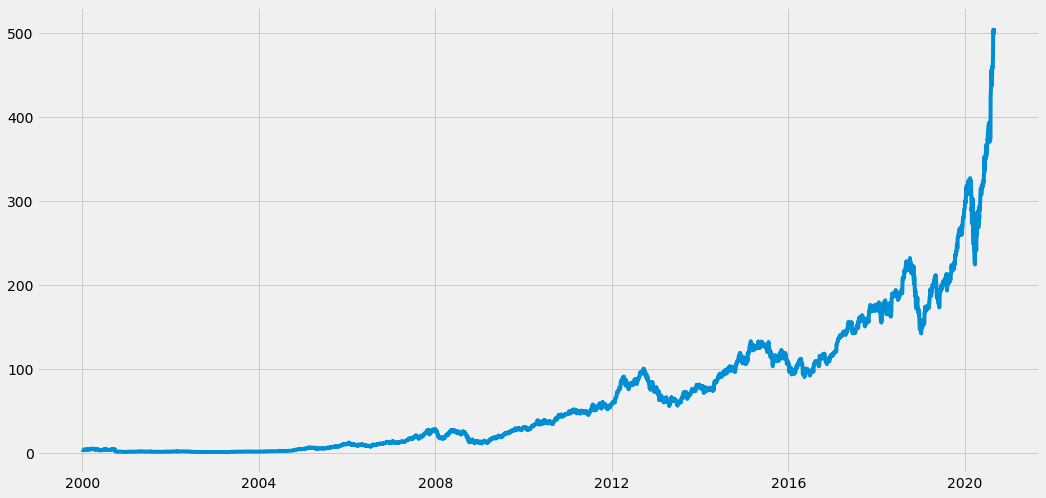

In [16]:
data["Date"]=pd.to_datetime(data.Date,format="%Y-%m-%d")
data.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(data["Close"],label='Close Price history')

Format dataset

In [25]:
df = data.sort_index(ascending=True,axis=0)
new_dataset = pd.DataFrame(index=range(0,len(df)),columns=['Close'])

for i in range(0,len(data)):
    new_dataset["Close"][i] = data["Close"][i]

Prepare training and testing sets

In [18]:
scaler=MinMaxScaler(feature_range = (0,1))
final_dataset = new_dataset.values
train_data = final_dataset[0:5031,:]
valid_data = final_dataset[5031:,:]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)
x_train_data, y_train_data = [],[]

for i in range(33, len(train_data)):
    x_train_data.append(scaled_data[i-33:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0],x_train_data.shape[1],1))

Setup the model

In [19]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-33:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

Compile the model

In [20]:
model.compile(loss='mean_squared_error',optimizer='adam')

Train the model

In [21]:
model.fit(x_train_data,y_train_data,epochs=1,batch_size=1)

4998/4998 [==============================] - 64s 13ms/step - loss: 1.8267e-04


In [26]:
X_test = []

for i in range(33,inputs_data.shape[0]):
    X_test.append(inputs_data[i-33:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_closing_price = model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [27]:
model.save("model.h5")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



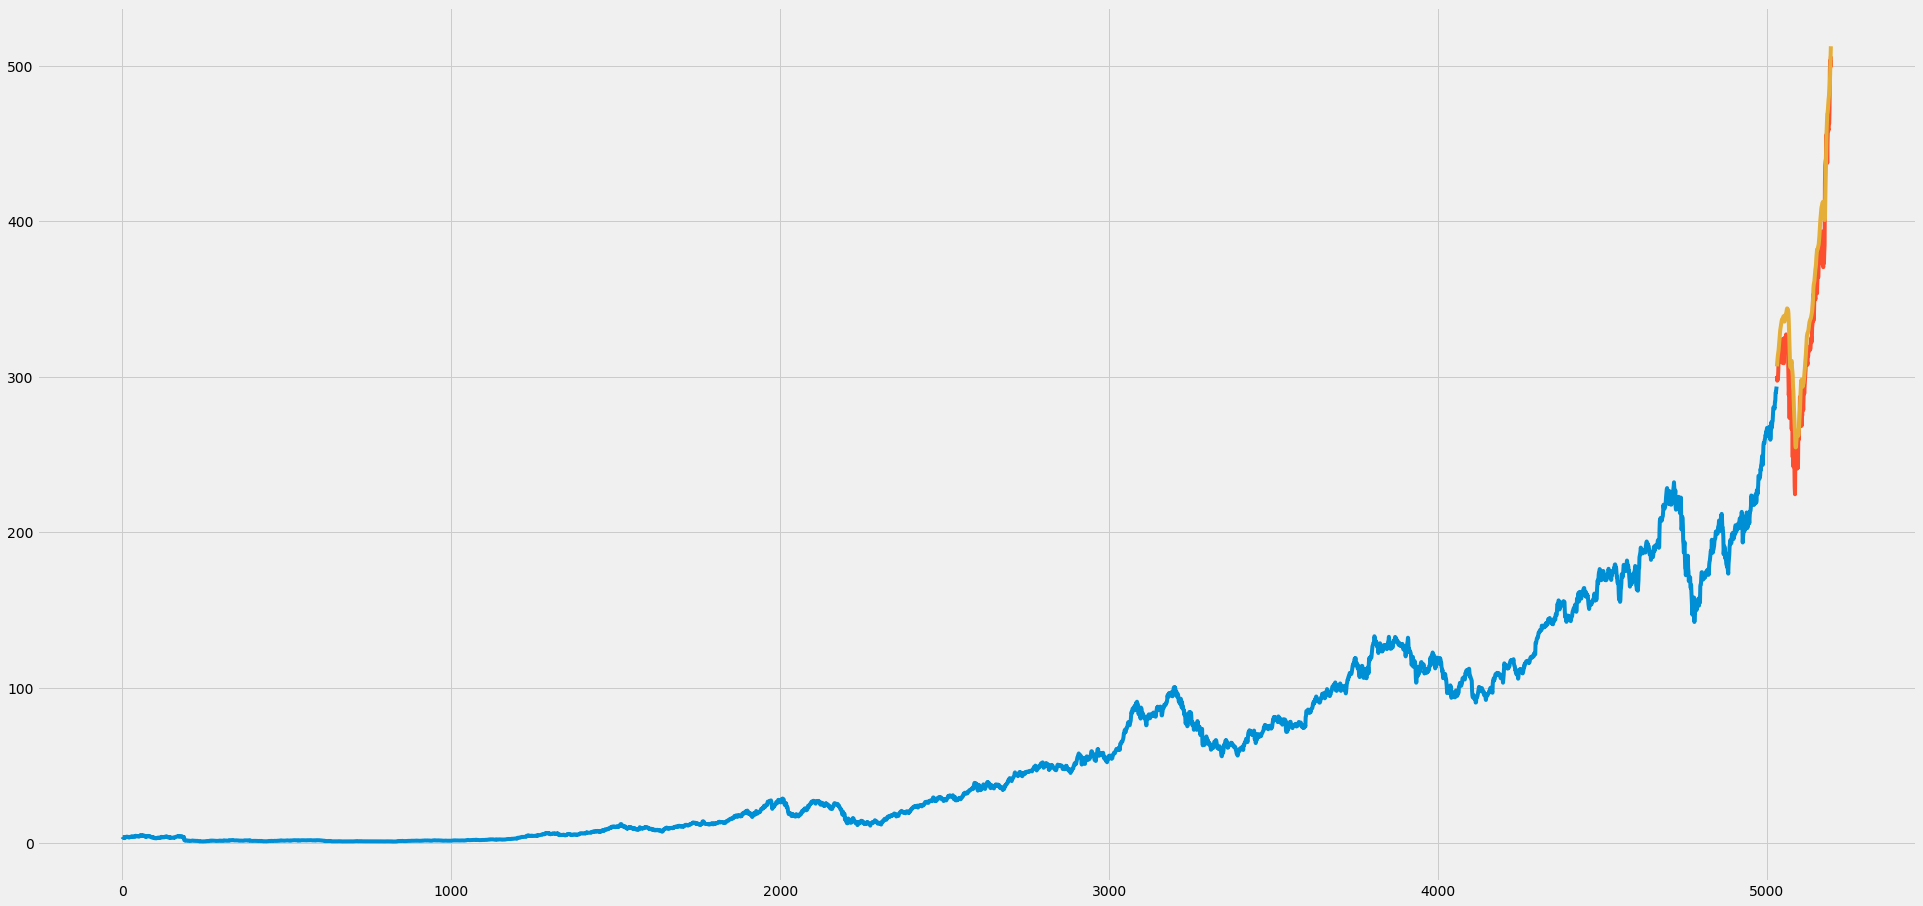

In [28]:
train_data = new_dataset[:5031]
valid_data = new_dataset[5031:]
valid_data['Predictions'] = predicted_closing_price
plt.figure(figsize=(30,15))
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

Blue line - actual price, red line - predicted price

In [29]:
df = valid_data
fig = px.line(df, y = "Close")
fig.add_scatter(y = df["Predictions"], mode='lines')
fig.show()